Previously, we were saying we know mu and sigma, so now generate fake data based on them. Now, we already have the data, and we're saying "given the data, what are the most likely values of the hidden parameters (z', theta) that generated it?"

h is a function that could be defined in many ways. It can adapt to the data by learning the best parameters. h is parameterized on theta. Let's invent some class of functions h of theta for now
    - let's choose a gaussian function and let parameters theta control its shape
        - amp: how tall each pulse is
        - width: how wide or narrow each pulse is
    - the shape of our heartbeat (kernel) will now depend on theta (amplitude and width)

During inference, let's sample from the posterior (updated beliefs abt unknown params) over amp and width to find what values best explain our observed signal, y(t).

y(t) = observed data
z' = time between heartbeats
theta = parameters of the kernel heartbeat, h_theta(t)

GOAL: infer z' and theta from y(t)

In [50]:
import numpy as np
from numpyro import sample, plate
import matplotlib.pyplot as plt
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
import jax
import jax.random as random


In [51]:
# GENERATE SYNTHETIC DATA

# generate 10 heartbeats, interval 1.0s
num_beats = 10
true_z_prime = np.ones(num_beats)  # 1 beat every 1s for 20s
spike_times = np.cumsum(true_z_prime)  # get actual times for each beat

# ground truth h kernel params (amp and width)
true_amp = 1
true_width = .1

# time domain (steps from 0s - 20s)
t = np.linspace(0, 10, 1000)

# gaussian kernel function h(theta)
# loop thru all times when beats occur and for each spike, add gaussian bump to signal time.
# then, sum all contributions to get combined effect
def heartbeat_kernel(t, spike_times, amp, width):
    signal = np.zeros_like(t)
    for s in spike_times:
        signal += amp * np.exp(-0.5 * ((t - s) / width) ** 2)
    return signal

# Observed signal y(t) = x * h(theta) + noise
x = np.ones_like(t)  # ECG signal is constant (for simplicity)
y_obs = heartbeat_kernel(t, spike_times, true_amp, true_width) + np.random.normal(0, 0.05, size=t.shape)


In [52]:
# DEFINE MODEL

# sample z', convert to spike times, create signal by adding pulses shaped by theta (amp, width)
# GOAL: infer params of h
def model(t, x, y_obs, num_beats):
    # prior for h parameters (theta), both must be non negative
    amp = sample("amp", dist.HalfNormal(1.0))
    width = sample("width", dist.HalfNormal(0.3))
    
    # prior over z_prime (between-beat intervals)
    # sample independent between-beat intervals z'
    with plate("beats", num_beats):
        z_prime = sample("z_prime", dist.TruncatedNormal(0.8, 0.3, low=0.5))  # truncated norm to make sure no between beat gets below 0.5s
    
    # cumulative sum of z_prime to get spike times
    # gives us heartbeat times at which each beat kernel will be centered
    spike_times = jnp.cumsum(z_prime)

    # generate heartbeat signal h_theta(t) using the kernel
    def h_single(s):
        return amp * jnp.exp(-0.5 * ((t - s) / width) ** 2)

    # loop over spike times, generate pulse for each one
    # creates 2d array, 1 row per pulse
    # sum makes it into 1 waveform to model a single heartbeat signal
    # predicted signal, commpare to real signal later
    y_hat = jnp.sum(jnp.stack([h_single(s) for s in spike_times]), axis=0)

    # Likelihood: Gaussian noise around true y_obs
    sigma_noise = 0.05  # fixed noise level
    sample("obs", dist.Normal(y_hat, sigma_noise), obs=y_obs)

In [53]:
# MCMC

kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=500, num_samples=1000)
mcmc.run(random.PRNGKey(0), t=jnp.array(t), x=jnp.array(x), y_obs=jnp.array(y_obs), num_beats=num_beats)
posterior_samples = mcmc.get_samples()

mcmc.print_summary()

sample: 100%|██████████| 1500/1500 [00:23<00:00, 64.72it/s, 31 steps of size 7.96e-02. acc. prob=0.92] 


                mean       std    median      5.0%     95.0%     n_eff     r_hat
       amp      1.00      0.01      1.00      0.99      1.00    745.82      1.00
     width      0.10      0.00      0.10      0.10      0.10    766.49      1.00
z_prime[0]      1.00      0.00      1.00      1.00      1.00    918.35      1.00
z_prime[1]      1.00      0.00      1.00      1.00      1.00    636.74      1.00
z_prime[2]      1.00      0.00      1.00      0.99      1.00    754.54      1.00
z_prime[3]      2.00      0.00      2.00      2.00      2.01   1211.92      1.00
z_prime[4]      1.00      0.00      1.00      1.00      1.00   1139.34      1.00
z_prime[5]      2.00      0.00      2.00      2.00      2.01   1500.87      1.00
z_prime[6]      1.00      0.00      1.00      0.99      1.00    924.00      1.00
z_prime[7]      1.00      0.00      1.00      0.99      1.00    776.61      1.00
z_prime[8]      0.88      0.24      0.84      0.50      1.21    520.62      1.00
z_prime[9]      0.89      0

In [54]:
# COMPARE INFERENCE RESULTS

# compare mean estimates vs true values
z_est = np.mean(posterior_samples["z_prime"], axis=0)
amp_est = np.mean(posterior_samples["amp"])
width_est = np.mean(posterior_samples["width"])

print("/n true vs estimated:")
print(f"amp:   true={true_amp:.3f},  estimated={amp_est:.3f}")
print(f"width: true={true_width:.3f}, estimated={width_est:.3f}")
print(f"z′[0:5]:\n  true={true_z_prime[:5]}\n  est.={z_est[:5]}")

/n true vs estimated:
amp:   true=1.000,  estimated=0.997
width: true=0.100, estimated=0.101
z′[0:5]:
  true=[1. 1. 1. 1. 1.]
  est.=[0.99990547 0.99935675 0.99868095 2.001789   1.0003774 ]


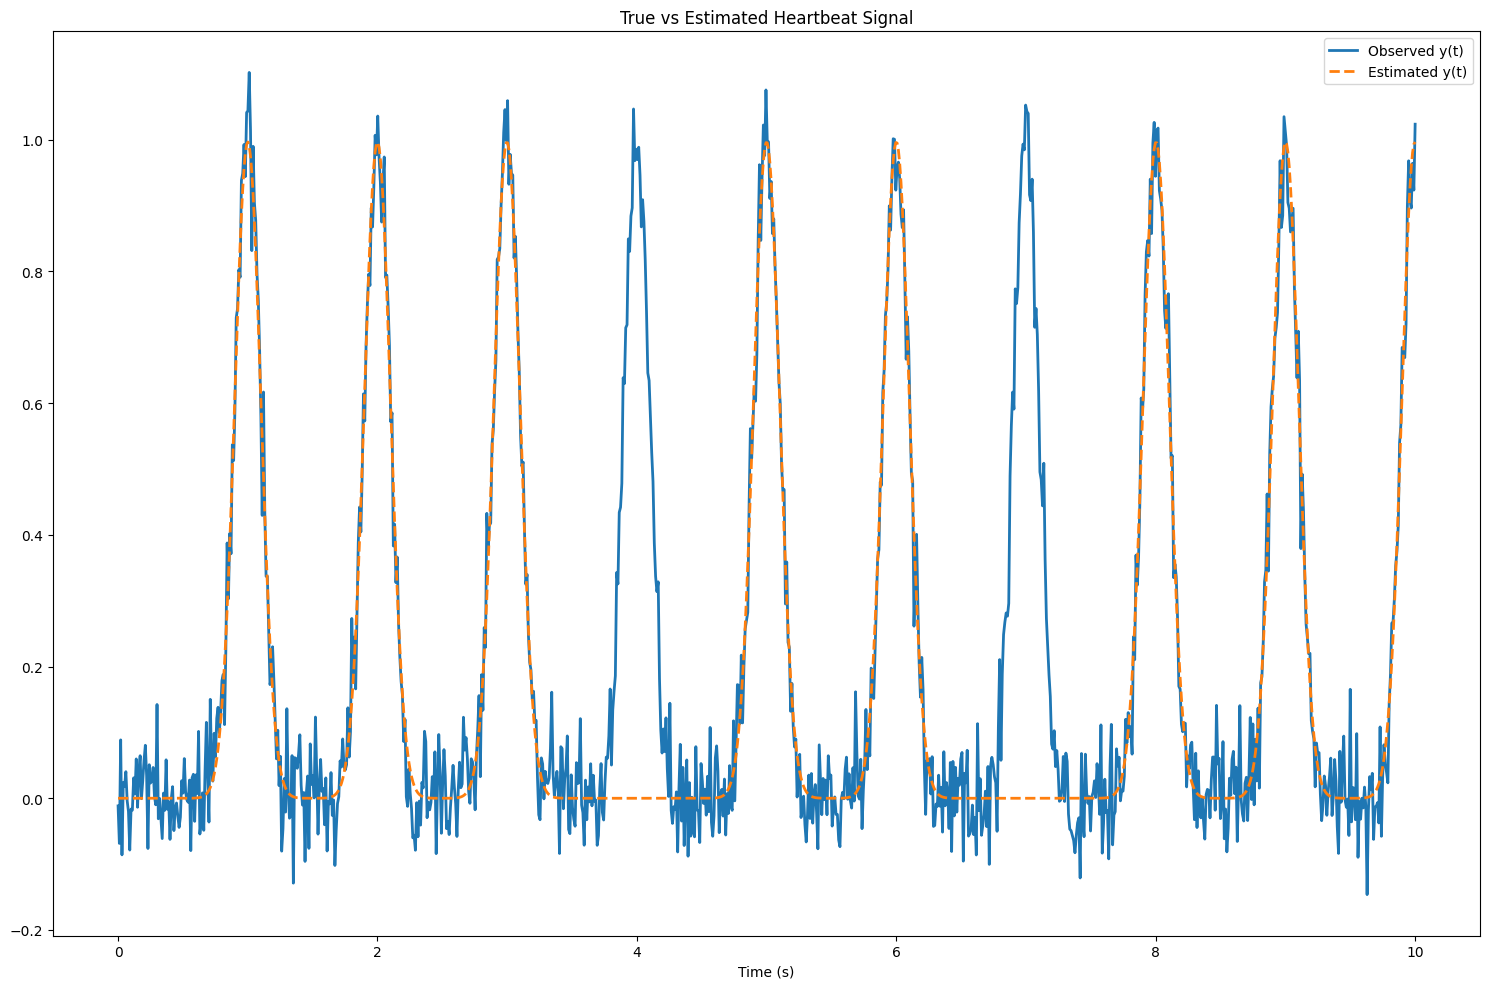

In [55]:
# PLOT
y_est = heartbeat_kernel(t, np.cumsum(z_est), amp_est, width_est)

plt.figure(figsize=(15, 10))
plt.plot(t, y_obs, label="Observed y(t)", lw=2)
plt.plot(t, y_est, label="Estimated y(t)", lw=2, linestyle='--')
plt.title("True vs Estimated Heartbeat Signal")
plt.xlabel("Time (s)")
plt.legend()
plt.tight_layout()
plt.show()

sample: 100%|██████████| 1500/1500 [00:17<00:00, 86.55it/s, 15 steps of size 1.87e-01. acc. prob=0.93] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
       amp      0.26      0.00      0.27      0.26      0.27    735.97      1.00
     width      1.16      0.02      1.16      1.13      1.18    668.58      1.00
z_prime[0]      1.79      0.03      1.80      1.75      1.84    630.32      1.01
z_prime[1]      2.99      0.03      2.99      2.94      3.04    697.27      1.00
z_prime[2]      2.94      0.03      2.94      2.89      2.99    877.50      1.00
z_prime[3]      3.38      0.04      3.39      3.30      3.45    529.13      1.00
z_prime[4]      0.58      0.06      0.56      0.50      0.67    526.59      1.00
z_prime[5]      0.55      0.05      0.54      0.50      0.61   1348.97      1.00
z_prime[6]      0.59      0.09      0.57      0.50      0.71   1101.22      1.00
z_prime[7]      0.74      0.20      0.69      0.50      1.02   1503.87      1.00
z_prime[8]      0.85      0.23      0.82      0.50      1.17    645.16      1.00
z_prime[9]      0.90      0

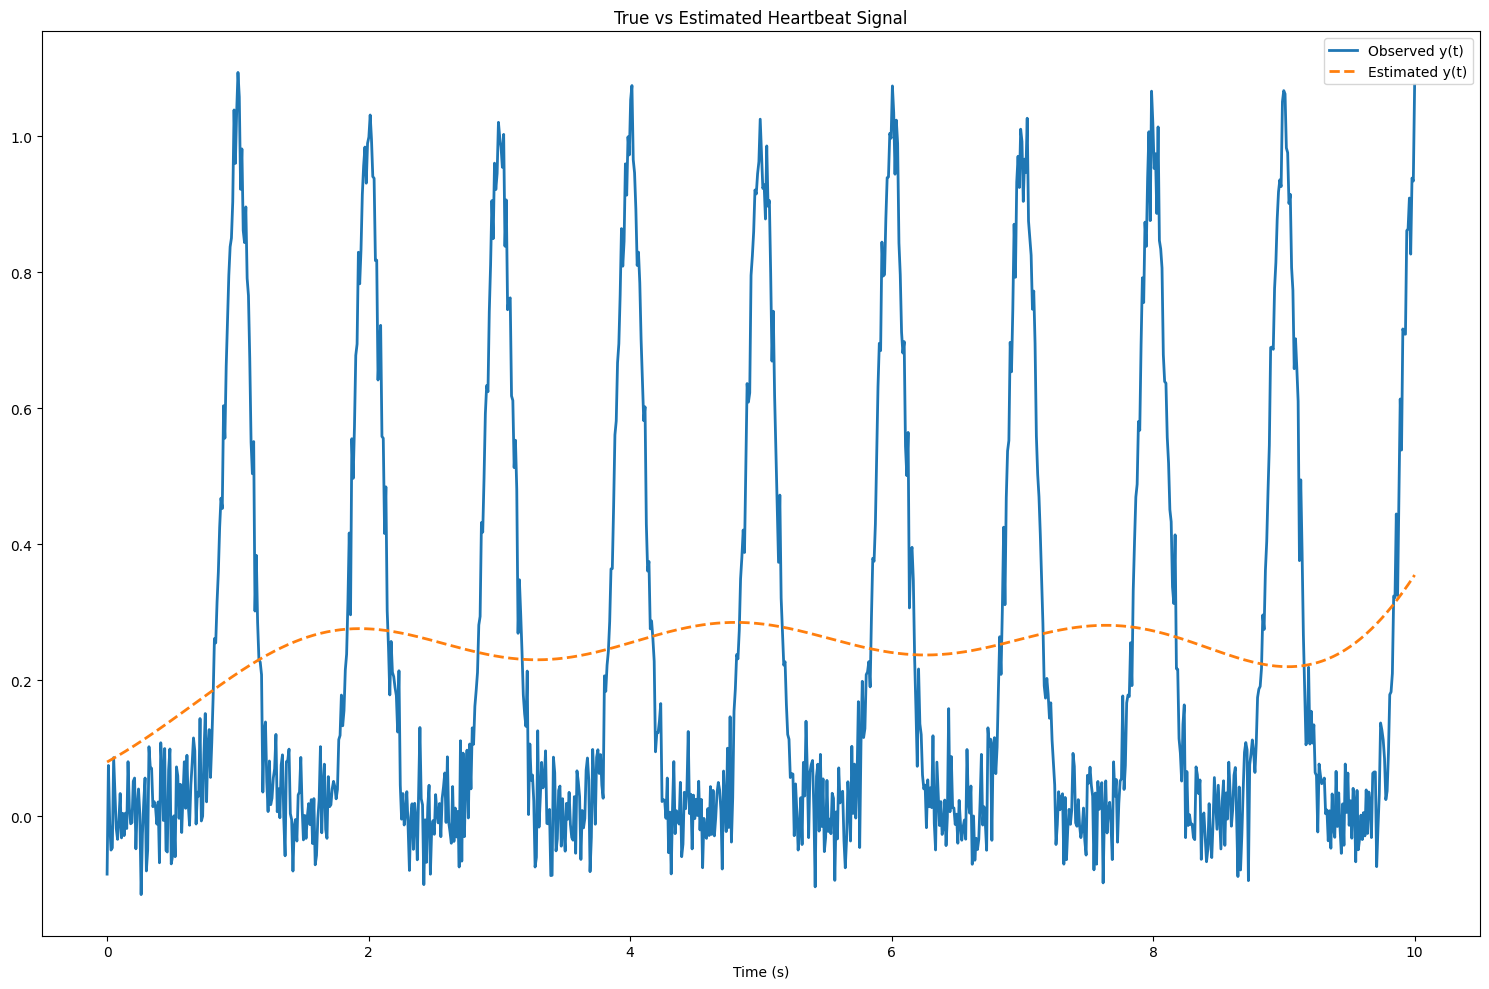

In [49]:
# LOOSER PRIORS

# sample z', convert to spike times, create signal by adding pulses shaped by theta (amp, width)
def model_loose(t, x, y_obs, num_beats):
    # prior for h parameters (theta), both must be non negative
    amp = sample("amp", dist.HalfNormal(5.0))
    width = sample("width", dist.HalfNormal(1.0))
    
    # prior over z_prime (between-beat intervals)
    # sample independent between-beat intervals z'
    with plate("beats", num_beats):
        z_prime = sample("z_prime", dist.TruncatedNormal(0.8, 0.3, low=0.5))  # truncated norm to make sure no between beat gets below 0.5s
    
    # cumulative sum of z_prime to get spike times
    # gives us heartbeat times at which each beat kernel will be centered
    spike_times = jnp.cumsum(z_prime)

    # generate heartbeat signal h_theta(t) using the kernel
    def h_single(s):
        return amp * jnp.exp(-0.5 * ((t - s) / width) ** 2)

    # loop over spike times, generate pulse for each one
    # creates 2d array, 1 row per pulse
    # sum makes it into 1 waveform to model a single heartbeat signal
    # predicted signal, commpare to real signal later
    y_hat = jnp.sum(jnp.stack([h_single(s) for s in spike_times]), axis=0)

    # Likelihood: Gaussian noise around true y_obs
    sigma_noise = 0.05  # fixed noise level
    sample("obs", dist.Normal(y_hat, sigma_noise), obs=y_obs)


# MCMC

kernel = NUTS(model_loose)
mcmc = MCMC(kernel, num_warmup=500, num_samples=1000)
mcmc.run(random.PRNGKey(1), t=jnp.array(t), x=jnp.array(x), y_obs=jnp.array(y_obs), num_beats=num_beats)
posterior_samples = mcmc.get_samples()

mcmc.print_summary()


# COMPARE INFERENCE RESULTS

# compare mean estimates vs true values
z_est = np.mean(posterior_samples["z_prime"], axis=0)
amp_est = np.mean(posterior_samples["amp"])
width_est = np.mean(posterior_samples["width"])

print("/n true vs estimated:")
print(f"amp:   true={true_amp:.3f},  estimated={amp_est:.3f}")
print(f"width: true={true_width:.3f}, estimated={width_est:.3f}")
print(f"z′[0:5]:\n  true={true_z_prime[:5]}\n  est.={z_est[:5]}")


# PLOT
y_est = heartbeat_kernel(t, np.cumsum(z_est), amp_est, width_est)

plt.figure(figsize=(15, 10))
plt.plot(t, y_obs, label="Observed y(t)", lw=2)
plt.plot(t, y_est, label="Estimated y(t)", lw=2, linestyle='--')
plt.title("True vs Estimated Heartbeat Signal")
plt.xlabel("Time (s)")
plt.legend()
plt.tight_layout()
plt.show()
